# AI502/KSE527, Homework 02

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm

from ptflops import get_model_complexity_info 

%matplotlib notebook
%matplotlib inline


import matplotlib.pyplot as plt
from matplotlib import style
## Reference of ptflops: https://github.com/sovrasov/flops-counter.pytorch

# CIFAR100

In [2]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 128
NUM_EPOCH = 100
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [3]:
# CIFAR100 Dataset
train_dataset = dsets.CIFAR100(root='./data', train=True, 
                              transform=transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]), download=True)
test_dataset = dsets.CIFAR100(root='./data', train=False,
                             transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [4]:
for i in train_loader:
    print (i[0][0].shape)
    break

torch.Size([3, 32, 32])


# Fit / Eval function

In [5]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #losses = []
    #for epoch in range(NUM_EPOCH):
    for i, data in enumerate(train_loader):
            #for t in tqdm(train_loader):

        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
            #losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            #tqdm._instances.clear()
    #print(f"Epoch: {epoch}. Loss: {loss}")
    #losses.append(loss)
    return (loss)
    #plt.plot(losses)
    #plt.show()
    #print(losses)
    avg_loss = sum(losses)/len(losses)   
    print (f"Avg Loss = {avg_loss}")
    

In [6]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []
    
    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
    
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    #accuracies.append(acc)
    #plt.plot(accuracies)
    #plt.show()
    return acc

In [7]:
from datetime import datetime
def run(model):
    
    start_time = datetime.now()
    accuracies = []
    losses = []

    for epoch in range(NUM_EPOCH):
        x = fit(model, train_loader)
        y = eval(model, test_loader)
        #losses.append (loss)
        #accuracies.append (acc)
        #return x, y
        losses.append(x)
        accuracies.append(y)
    
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    fig = plt.figure() 
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 12})

    #define axis, each axis is a graph
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(losses, label="training_loss")
    ax1.legend(loc=2)
    #ax1.plot(accuracies, label="test_accuracy")
    #ax1.legend(loc=2)
    ax2.plot(accuracies, label="test_accuracy")
    ax2.legend(loc=2)
    #ax2.legend(loc=2)
    plt.show() 
    #fig.savefig(('/home/trojan/Desktop/defected_area2.png'))
    
    return losses, accuracies


# Construct the 18 layers network

All of PlainNet18, ResNet18, MobileNet18 have same network structure but they are consist of different convolution block (PlainBlock, ResidualBlock, MobileBlock). You have to utilize Net18() when you define the network.

In [8]:
# Example

#plainnet_model = Net18(PlainBlock, [2, 2, 2, 2], 100).cuda()
# resnet_model = Net18(ResidualBlock, [2, 2, 2, 2], 100).cuda()
# mobilenet_model = Net18(MobileBlock, [2, 2, 2, 2], 100).cuda()

In [9]:
class Net18(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(Net18, self).__init__()
        self.inp = 64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, oup, num_block, stride=1):
        layers = []
        strides = [stride] + [1]*(num_block-1)
        for stride in strides:
            layers.append(block(self.inp, oup, stride))
            self.inp = oup
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn0(self.conv0(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# Task1 : Implement 18-layer CNNs for CIFAR100

In [10]:
class PlainBlock(nn.Module):
    #expansion = 1
    def __init__(self, inp, oup, stride=1):
        super(PlainBlock, self).__init__()
        
        #####################################
        
        # Write down your own code

        self.plain_function = nn.Sequential(
            nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True),
            nn.Conv2d(oup, oup, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(oup)
        )

        
        
        #####################################
        
    def forward(self, x):
        
        #####################################
        
        # Write down your own code
        out = nn.ReLU(inplace=True)(self.plain_function(x))
        #####################################
        
        return out

In [11]:
plainnet_model = Net18(PlainBlock, [2, 2, 2, 2], 100).cuda()

In [12]:
print (plainnet_model)

Net18(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): PlainBlock(
      (plain_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): PlainBlock(
      (plain_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d

In [13]:
torch.cuda.is_available()


True

In [14]:
device = torch.device("cuda:0")
device


device(type='cuda', index=0)

In [15]:
#.to(device) tensor to device)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on CPU")

running on GPU


Duration: 0:41:02.344969


<Figure size 432x288 with 0 Axes>

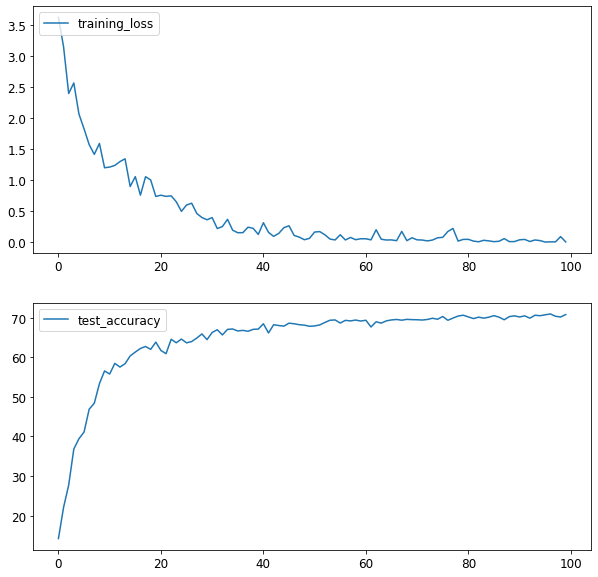

([tensor(3.6147, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(3.1432, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.3918, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.5616, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.0619, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.8234, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.5698, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.4136, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.5889, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.1980, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.2356, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.2971, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.3423, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.8972, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.0556, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor

In [16]:
run(plainnet_model)

# Task2 : Implement ResNet18 for CIFAR100

In [17]:
class ResidualBlock(nn.Module):
    """Residual Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block 
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, inp, oup, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True),
            nn.Conv2d(oup, oup * ResidualBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(oup * ResidualBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or inp != ResidualBlock.expansion * oup:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inp, oup * ResidualBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(oup * ResidualBlock.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))



In [18]:
resnet_model = Net18(ResidualBlock, [2, 2, 2, 2], 100).cuda()

In [19]:
print(resnet_model)

Net18(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

Duration: 0:43:24.401153


<Figure size 432x288 with 0 Axes>

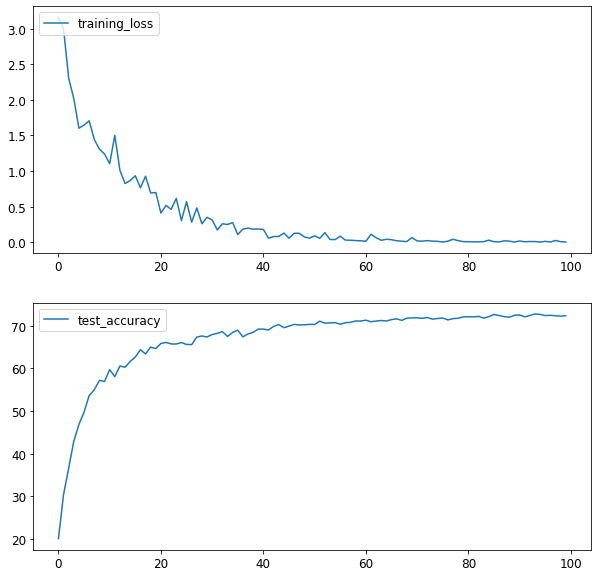

([tensor(3.1570, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.9964, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.0158, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.6006, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.6458, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.7049, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.4422, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.3065, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.2386, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.1029, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.4989, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.0091, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.8242, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.8644, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(0.9329, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor

In [20]:
run(resnet_model)

# Task3 : Implement MobileNet for CIFAR100

In [21]:
class DepthSeperabelConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                **kwargs),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True)
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):

        super().__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class MobileNet(nn.Module):

    """
    Args:
        width multipler: The role of the width multiplier α is to thin 
                         a network uniformly at each layer. For a given 
                         layer and width multiplier α, the number of 
                         input channels M becomes αM and the number of 
                         output channels N becomes αN.
    """

    def __init__(self, width_multiplier=1, class_num=100):
       super().__init__()

       alpha = width_multiplier
       self.stem = nn.Sequential(
           BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv1 = nn.Sequential(
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(128 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv2 = nn.Sequential(
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(256 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(256 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv3 = nn.Sequential(
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(512 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),

           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv4 = nn.Sequential(
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(1024 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(1024 * alpha),
               int(1024 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       self.fc = nn.Linear(int(1024 * alpha), class_num)
       self.avg = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def mobilenet(alpha=1, class_num=100):
    return MobileNet(alpha, class_num)

In [22]:
net = MobileNet().cuda()
print(net)

MobileNet(
  (stem): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (conv1): Sequential(
    (0): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
  

Duration: 0:21:52.884338


<Figure size 432x288 with 0 Axes>

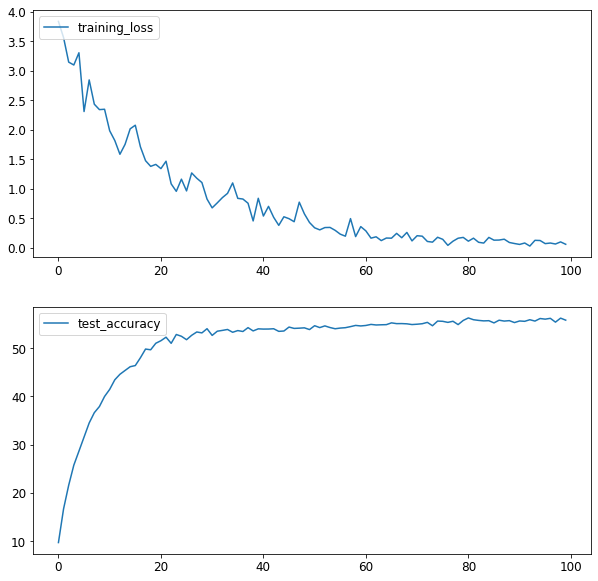

([tensor(3.8348, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(3.5610, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(3.1461, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(3.0969, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(3.3042, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.3089, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.8443, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.4331, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.3415, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.3476, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.9835, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.8179, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.5853, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(1.7527, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.0162, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor(2.0772, device='cuda:0', grad_fn=<NllLossBackward>),
  tensor

In [23]:
run(net)

In [37]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = MobileNet()
  macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNet(
  3.315 M, 100.000% Params, 0.048 GMac, 100.000% MACs, 
  (stem): Sequential(
    0.004 M, 0.106% Params, 0.004 GMac, 7.798% MACs, 
    (0): BasicConv2d(
      0.001 M, 0.028% Params, 0.001 GMac, 2.052% MACs, 
      (conv): Conv2d(0.001 M, 0.026% Params, 0.001 GMac, 1.847% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(0.0 M, 0.002% Params, 0.0 GMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.068% MACs, inplace=True)
    )
    (1): DepthSeperabelConv2d(
      0.003 M, 0.078% Params, 0.003 GMac, 5.746% MACs, 
      (depthwise): Sequential(
        0.0 M, 0.011% Params, 0.0 GMac, 0.821% MACs, 
        (0): Conv2d(0.0 M, 0.009% Params, 0.0 GMac, 0.616% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(0.0 M, 0.002% Params, 0.0 GMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, 

In [49]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(resnet_model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Net18(
  11.22 M, 100.000% Params, 0.557 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.015% Params, 0.002 GMac, 0.318% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
  (layer1): Sequential(
    0.148 M, 1.319% Params, 0.152 GMac, 27.226% MACs, 
    (0): ResidualBlock(
      0.074 M, 0.659% Params, 0.076 GMac, 13.613% MACs, 
      (residual_function): Sequential(
        0.074 M, 0.659% Params, 0.076 GMac, 13.613% MACs, 
        (0): Conv2d(0.037 M, 0.329% Params, 0.038 GMac, 6.777% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012%

In [43]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(plainnet_model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Net18(
  11.046 M, 100.000% Params, 0.551 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.016% Params, 0.002 GMac, 0.321% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
  (layer1): Sequential(
    0.148 M, 1.340% Params, 0.152 GMac, 27.543% MACs, 
    (0): PlainBlock(
      0.074 M, 0.670% Params, 0.076 GMac, 13.771% MACs, 
      (plain_function): Sequential(
        0.074 M, 0.670% Params, 0.076 GMac, 13.771% MACs, 
        (0): Conv2d(0.037 M, 0.334% Params, 0.038 GMac, 6.856% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs